# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [ ]:
candidateno=260823 #this MUST be updated to your candidate number so that you get a unique data sample


In [ ]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [ ]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [ ]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['in', '1998', ',', 'director', 'brett', 'ratner', ...], 'pos')


In [ ]:
training_data[32:35]

[(['kadosh', 'means', 'sacred', 'in', 'hebrew', '.', ...], 'pos'),
 (['note', ':', 'some', 'may', 'consider', 'portions', ...], 'pos'),
 (['capsule', ':', 'the', 'verma', 'family', 'is', ...], 'pos')]

In [ ]:
testing_data[0]

(['krippendorf', "'", 's', 'tribe', 'is', 'a', ...], 'pos')

In [ ]:
testing_wordlist,label= zip(*testing_data)

1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [ ]:
testing_basic=[(FreqDist(wordlist),label) for (wordlist,label) in testing_data]
testing_basic[0]

(FreqDist({',': 29, 'the': 26, '.': 25, 'of': 15, 'his': 13, 'a': 12, 'to': 11, 'is': 9, 'in': 9, 'tribe': 8, ...}),
 'pos')

In [ ]:
#Removing stopwords from the test and train data
stop = stopwords.words('english')
def stopwords_removal(alist):
   '''
   Given a collection of lower-case tokens, the function removes stop words from
    the list.
   :param alist: A list of words
   :return: a list of alphanumeric words without any stopwords and punctuations.
   '''
   newlist= []
   for word in alist:
      if word.isalpha() and word not in stop:
        filtered_tokens= word
        newlist.append(filtered_tokens)
   return newlist

In [ ]:
def normalized_fq(alist):
  '''
  Given a list of words and their corresponding labels, the function removes
    stopwords from the bag of words and finds the frequency distribution of each type in a review.

  :param alist: A list of a pair of tuples. The first part of the tuple is a list of words,
    the second part of the tuple is the review class that the list belongs to.
  :return: A list of a pair of tuples. The first part is a list of frequency distribution of types,
    and second part is the corresponding class of the list.
  '''
  alist_norm= []

  for i in range(len(alist)):
    label= alist[i][1]
    fq= FreqDist(stopwords_removal(alist[i][0]))
    alist_norm.append((fq, label))
  return alist_norm

training_norm= normalized_fq(training_data)
testing_norm= normalized_fq(testing_data)

In [ ]:
training_norm[34]

(FreqDist({'family': 13, 'indian': 7, 'wedding': 4, 'film': 4, 'films': 4, 'like': 4, 'mira': 3, 'nair': 3, 'us': 3, 'together': 3, ...}),
 'pos')

In [ ]:
testing_norm[20]

(FreqDist({'impact': 6, 'film': 5, 'deep': 5, 'disaster': 5, 'news': 4, 'even': 3, 'snicker': 3, 'comet': 3, 'characters': 3, 'personal': 3, ...}),
 'pos')

In [ ]:
def list_generation(alist):

  '''
  Generates a list of frequency distributions for the positive and negative classes,

  param: alist: A list of a pair of tuples. The first part is a list of frequency distribution of types,
    and second part is the corresponding class of the list.

  return: A pair of tuples, The first part represents the frequency distribution of words in the positive class,
    the second part is the frequency distribution of words in the negative class
  '''

  class1_fq= []
  class2_fq= []

  for words,label in alist:
    if label=='pos':
        class1_fq+=words
        class1_fq= FreqDist(class1_fq)             # adds a word into the empty list, then finds its frequency distribution
    else:
        class2_fq+=words
        class2_fq= FreqDist(class2_fq)

  return (class1_fq, class2_fq)

posWordlist= list_generation(training_norm)[0]
negWordlist= list_generation(training_norm)[1]
posWordlist

FreqDist({'film': 3658, 'one': 2150, 'movie': 1752, 'like': 1295, 'good': 903, 'story': 875, 'even': 851, 'time': 844, 'also': 815, 'well': 808, ...})

In [ ]:
negWordlist

FreqDist({'film': 3093, 'movie': 2300, 'one': 1971, 'like': 1328, 'even': 968, 'good': 833, 'time': 828, 'would': 762, 'bad': 758, 'get': 744, ...})

In [ ]:
def most_frequent_words(fq1,fq2, k=10):
    '''
    Given two frequency distributions and a number, the function finds the words that appear more in fq1 than fq2.
    and returns the top k words with the highest difference
    :params fq1 and fq2: Frequency distributions of types
    :param k: A number

    :return: a list of k words that appear the most in fq1 than fq2
    '''
    difference=fq1-fq2
    diff=difference.most_common(k)
    fq1_topk= [diff[i][0] for i in range(len(diff))]
    return fq1_topk

In [ ]:
#Generating 10 most frequent positive wordlist
positive_wordlist=most_frequent_words(posWordlist,negWordlist)
print(positive_wordlist)


['film', 'life', 'also', 'best', 'well', 'great', 'world', 'story', 'films', 'one']


In [ ]:
#Generating 10 most frequent negative wordlist
negative_wordlist=most_frequent_words(negWordlist, posWordlist)
print(negative_wordlist)


['movie', 'bad', 'plot', 'worst', 'nothing', 'supposed', 'get', 'script', 'even', 'stupid']


**How to Generate Content Words that are Representatives of The Positive and Negative Reviews**

**Training and Testing Data Normalisation**

Generating automatic lists from the data requires a preprocessing of the document. Removing stop-words and punctuation marks from the training and testing data is a good preprocessing option, because it removes the non-informative words that do not express any sentiment from the data. Doing this pre-processing step drastically reduces the size of the training and testing data, and made them more effective and efficient to work with. Using the stopwords_removal function helped achieve this normalisation process.

*The stopwords_removal Function*

Purpose- Given a list of lower-case tokens, the function removes stop words from the list.
Parameter- alist: A list of a pair of tuples consisting of a list of tokens, and their corresponding label (positive or negative).
Return- A list of tuples. The first part of the tuple is a list of alphanumeric tokens without any stopwords and punctuations. The second part is the corresponding label of the list of tokens.

**Counting Types in Each Review**

The second step of generating the lists involves finding the frequency of word types in each review of the normalized testing and training data. Applying the Frequency Distribution method on the normalized training and testing lists produces a dictionary of types as keys, and their frequency of occurrence as values. By finding the frequency of each type, it will be easier to know the most relevant words in each review.

*The normalized_fq Function*

Purpose- Given a list of a pair of words and their corresponding labels, the function calls the stopwords_removal function (which removes punctuations and stop words from the data) and then finds the frequency distribution of each word type.
Parameter- alist: A list of a pair of tuples. The first part of the tuple is a list of tokens, the second part of the tuple is the label class that the list belongs to.
Return-  A list of a pair of tuples. The first part is a list of frequency distribution of word types, and second part is the corresponding class of the list.

**Generating Lists of Positive and Negative Words**

After finding the frequency of types in the training and testing data, the next step is to create two frequency distributions. One frequency distribution is of words that occur in positive reviews, the other is of words in negative reviews. By producing a frequency distribution of types in the two classes, we will be able to know the words which express the most sentiment.

*The list_generation Function*

Purpose- Generates a list of frequency distributions of types for the positive and negative classes.

Parameter- alist: A list of a pair of tuples. The first part is a list of frequency distribution of types in a review, and second part is the corresponding class of the list.

Return: A pair of tuples, The first part represents the frequency distribution of words in the positive class, the second part is the frequency distribution of words in the negative class.

*The most_frequent_words Function*

Purpose- Given two frequency distributions and an integer, the function finds the words that appear more in one frequency distribution than the other. And return a list of words of the length of the integer.

Parameters- fq1, fq2: These are frequency distributions of types in the positive and negative class

Parameter- k: An integer
Return- A list of words that appear the most in fq1 than fq2. The list has a length equal to the integer specified in the key arguments.


2)
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [ ]:
class WLClassifier(ClassifierI):

  '''
  The functions in this class are used to classify reviews.
  '''

  def __init__(self, pos, neg):
      '''
      This function take 2 lists of words. One list represents words that occur frequently in positive reviews,
      and the other list represents the most frequent words in negative reviews.
      These two lists are necessary for the classifier to work.
      '''
      self._pos = pos
      self._neg = neg

  def labels(self):
      return ("pos", "neg")

  def scoring(self, review):
      '''
      This function assigns a score to a single review. It adds word frequency to the score variable if a word in a review exists in the positive words list,
      and reduces the score by the word frequency if the word exists in the negative words list.

      :params: self: This refers to the two lists positive and negative of words generated in question 1.
      :param: words: This is a frequency distribution of words

      Return: The function returns the total score of the review.
      '''
      score = 0
      for word,count in review.items():
        if word in self._pos:
          score+=count
        if word in self._neg:
          score-=count
      return score

  def score_many(self, reviews):
        '''
        This function assigns scores to each review in a list of multiple reviews.

        params: reviews: These are a list of frequency distributions of multiple reviews.
        return: A list of scores of each review.
        '''

        return [self.scoring(review) for review in reviews]


  def classify(self, score):

      '''
      This function assigns each review to a class based on the score obtained from the self.scoring(review) function.
      Reviews with negative scores get labelled as negative (neg), reviews with positive scores get the
      positive label (pos), while reviews with scores equal to zero get a random label from the self.labels() function.
      '''
      if score < 0:
        theclass= 'neg'
      if score > 0:
        theclass= "pos"
      if score == 0:
        theclass= random.choice(self.labels())
      return theclass

  def classify_many(self, scores):
        '''
        This function classifies the score of each review in a list of reviews. These scores are obtained from the score_many function.

        params: scores: A list of scores of reviews.
        return: A list of classes (neg or pos) for each score in the list of scores.
        '''

        return [self.classify(score) for score in scores]

WLclassifier = WLClassifier(positive_wordlist, negative_wordlist)
score= WLclassifier.scoring(FreqDist(stopwords_removal("the movie was bad".split())))
WLclassifier.classify(score)

'neg'

In [ ]:
class MFW_Classifier(WLClassifier):

    def __init__(self, k):
        self._k=k

    def train(self,training_data):
      '''
      This function takes the labels and frequency distribution of words from each review of the training data.
      It divides the words into positive and negative lists, finds the frequencies of each word type, and then calls the most_frequent_words
      method from the WLClassifier to return two lists (negative and positive wordlists) with a maximum number of k words.

      '''
      posclass_fq= []
      negclass_fq= []
      for words,label in training_data:
        if label=='pos':
            posclass_fq+=words
            posclass_fq= FreqDist(posclass_fq)             # adds a word into the empty list, then finds its frequency distribution
        else:
            negclass_fq+=words
            negclass_fq= FreqDist(negclass_fq)

      #return (posclass_fq, negclass_fq)

      self._pos=most_frequent_words(posclass_fq,negclass_fq)
      self._neg=most_frequent_words(negclass_fq,posclass_fq)



**How to Classify a Review Using the Word List Classifier**

The word list classifier is an example of binary classification because classifies reviews as either positive or negative. When given a review, or a list of reviews, the WLClassifier takes the positive and negative word lists generated from question 1, and then uses the scoring and classify functions to determine whether each review is negative or positive.

*The scoring and score_many functions*

Purpose- The scoring function assigns a score to a single review. The score_many function takes a list of reviews, and calls the scoring function to assign a score to each review in the list. self.scoring(review) adds a word's frequency to the score variable if a word exists in the positive words list. It also reduces the score by the word frequency if the word exists in the negative words list.
       
Parameters- self: This refers to the two lists of positive and negative of words generated in question 1.
Parameter- words: This is a frequency distribution of words in a single review.
Return: The function returns the total score of the review.

*The classify and classify_many functions*

Purpose: The classify function assigns a class to each score obtained from the scoring function. The classify_many function takes the list of scores from the score_many function, calls the classify function and classifies each score in the list of scores. Reviews with negative scores get labelled as negative (neg), reviews with positive scores get the positive label (pos), while reviews with scores equal to zero get a random label (positive or negative).

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [ ]:
class ConfusionMatrix:

    '''
    Using the wordlist classifiers, this class takes the reviews classified as true positives,
    false positives, true negatives, and false negatives.
    It makes it possible to calculate the four evaluation metrics
    '''


    def __init__(self,predictions,goldstandard,classes=("pos","neg")):

        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1

            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1

    def accuracy(self):
      a= 0
      N= self.TP + self.FP + self.FN + self.TN
      a= (self.TP + self.TN)/N
      return a

    def precision(self):
        p=0
        p = self.TP/ (self.TP+ self.FP)
        return p

    def recall(self):
        r=0
        r = self.TP/ (self.TP+ self.FN)
        return r

    def f1(self):
        f1=0
        f1= (2 * self.precision() * self.recall())/ (self.precision() + self.recall())

        return f1

In [ ]:
#Training the data
reviewClassifier= MFW_Classifier(10)
reviewClassifier.train(training_norm)

In [ ]:
#Classifying the test data
reviews,goldstandard=zip(*testing_basic)
reviews_scores= reviewClassifier.score_many(reviews)
wordlist_predictions=reviewClassifier.classify_many(reviews_scores)

In [ ]:
#Evaluating the classifier
wordlist_matrix= ConfusionMatrix(wordlist_predictions,goldstandard)
WLClassifier_Performance= {'Accuracy': wordlist_matrix.accuracy(), 'Precision': wordlist_matrix.precision(),
                           'Recall': wordlist_matrix.recall(),
                           'F1': wordlist_matrix.f1()}
wordlist_evaluation = pd.DataFrame(WLClassifier_Performance, index= ['Word List Classifier'])
wordlist_evaluation


,Accuracy,Precision,Recall,F1
Word List Classifier,0.61,0.573009,0.863333,0.68883


Evaluating a classifier based on its accuracy is misleading in cases when the the classes are imbalanced. For example, if the training data had more positive reviews than negative reviews, the classifier would guess that most of the reviews in the testing data are also positive. It would, therefore, incorrectly predict the number of negative reviews in the data. In this case of imbalanced classes, it would be reasonable to use the classifier to only predict positive reviews.

Another technique that would help make accuracy a reliable evaluation method involves randomly resampling the training and testing data a number of times (e.g. 3 times). We would then use these three training samples to create the classifier. Next would be to get three different accuracies using the three testing samples and calculate their average. The average will be more reliable in making decisions on whether the classifier is helpful in making predictions.

4)
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results.

[12.5\%]

In [ ]:
#NLTK Naive Bayes Classifier
from nltk.classify import NaiveBayesClassifier
naivebayes_classifier=NaiveBayesClassifier.train(training_norm)

In [ ]:
#Classyfying the test data and evaluating the classifier
naivebayes_predictions= naivebayes_classifier.classify_many(reviews)
naivebayes_matrix= ConfusionMatrix(naivebayes_predictions,goldstandard)
naivebayesClassifier_Performance= {'Accuracy': naivebayes_matrix.accuracy(), 'Precision': naivebayes_matrix.precision(),
                                   'Recall': naivebayes_matrix.recall(), 'F1': naivebayes_matrix.f1()}
naivebayes_evaluation = pd.DataFrame(naivebayesClassifier_Performance, index= ['Naive Bayes Classifier'])
naivebayes_evaluation


,Accuracy,Precision,Recall,F1
Naive Bayes Classifier,0.756667,0.681604,0.963333,0.798343


In [ ]:
#Creating a dataframe of the metrics of the two classifiers
frames = [naivebayes_evaluation, wordlist_evaluation]
classifiers_comparison = pd.concat(frames)

classifiers_comparison= classifiers_comparison.transpose()

classifiers_comparison.rename(columns= {'index': 'Evaluation'}, inplace= True)

classifiers_comparison

,Naive Bayes Classifier,Word List Classifier
Accuracy,0.756667,0.610000
Precision,0.681604,0.573009
Recall,0.963333,0.863333
F1,0.798343,0.688830


Text(0.5, 0, 'Evaluation Type')

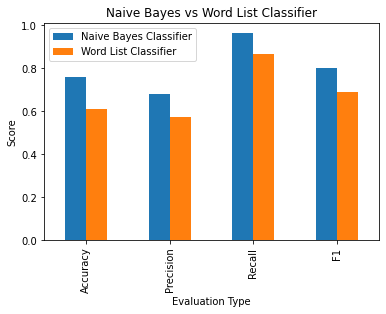

In [ ]:
#comparing the two classifiers
ax= classifiers_comparison.plot(kind="bar",title="Naive Bayes vs Word List Classifier")
ax.set_ylabel("Score")
ax.set_xlabel("Evaluation Type")

In [ ]:
##Checking the balance of the training data

words, i= zip(*training_data)
negcount= 0
poscount= 0
for j in i:
  if j =='neg':
    negcount+= 1
  if j =='pos':
    poscount+= 1
print('Training Data Positive Reviews: ',poscount)
print('Training Negative Reviews: ',negcount)

Training Data Positive Reviews:  700
Training Negative Reviews:  700


The evaluation scores of the Naive Bayes Classifier are higher than those of the word list classifier.

*Accuracy*

Because we have balanced binary classes, the accuracy score is a reliable way of evaluating these two classifiers. The Naive Bayes classifier, is therefore, likely to be correct in guessing that 76% of all reviews are positive. The word list classifier will correctly guess that 61% of all the reviews are positive.

*Recall*

The recall of the naive bayes is 96%- this means that for every 100 reviews in the data, 96 of them are classified as positive, but the other 4 reviews are wrongly classified as negative. On the other hand, the word list classifier correctly predicts only 86 positives reviews as positive, and wrongly predicts 14 positives as negatives.

*Precision*

In the Naive Bayes classifier for every 100 reviews classified as positive, only 68 are actually positive, while 32 wrongly classified as positives. This is about 11% higher than the word list classifier which has a precision of only 57% .

*F1 Score*

The naive bayes classifier has a higher harmonic mean than the word list classifier.


5)
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


In [ ]:
#Experimenting the effect of length on classifier
wordlist_length=list(range(10,700,50))
reviews,goldstandard=zip(*testing_basic)
accresults={}
precresults={}


for k in wordlist_length:
    #training the data and getting the wordlists of each k
    reviewClassifier= MFW_Classifier(k)
    reviewClassifier.train(training_norm)
    #Classifying the test data
    reviews_scores= reviewClassifier.score_many(reviews)
    predictions=reviewClassifier.classify_many(reviews_scores)
    #Evaluating the classifier
    matrix= ConfusionMatrix(predictions,goldstandard)

    accuracy=matrix.accuracy()
    prec = matrix.precision()
    accresults[k]=accuracy
    precresults[k]=prec





In [ ]:
#creating a dataframe of accuracy and precision of each wordlist length
df= pd.DataFrame([accresults, precresults], index=['Accuracy', 'Precision'])
df= df.transpose()
df

,Accuracy,Precision
10,0.610000,0.572368
60,0.598333,0.563991
110,0.605000,0.568627
160,0.603333,0.568282
210,0.603333,0.567686
260,0.600000,0.565789
310,0.596667,0.563319
360,0.601667,0.566161
410,0.606667,0.570485
460,0.606667,0.570796


(0.55, 0.7)

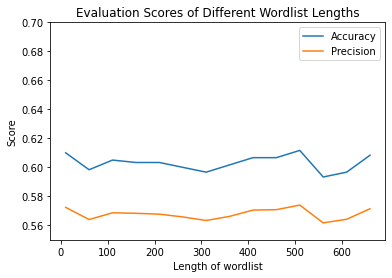

In [ ]:
#Comparing wordlist lengths metrics
ax = df.plot(kind="line",title="Evaluation Scores of Different Wordlist Lengths")
ax.set_ylabel("Score")
ax.set_xlabel("Length of wordlist")
ax.set_ylim(0.550,0.7)


**The Impact of wordlist length on the wordlist classifier**

To check the impact of different lengths of the wordlist on the classifier, the first step is to create a variable of type list, that takes integers of different magnitudes. The experiment in this case takes a list of 7 numbers of varying intensities. Each number is saved into the variable k. The second step is to give each of these numbers to the MFW_Classifier. This classifier returns two lists each of length k. These lists contain words that are the most relevant in the positive and negative classes. Using these different lengths of wordlists, the classifier predicts the label of each review in the testing_basic variable. The testing_basic variable is a frequency distribution of words in each review.
The final step in the experiment is to find the accuracy and precision of these predictions, by calling the these functions from the ConfusionMatrix matrix. The k variable(length of word list) is stored as a key in the results variable, and the evaluation score of the corresponding length is stored as a value.

*Results and Conclusion*

The results show that the length of the word list does not affect the accuracy and precision of the classifier by a large margin. There exists only a 0.01 difference in the maximum and minimum precisions and accuracies.

It is reasonable to conclude that words that appear at a higher frequency in a class are more reliable in classifying a review, compared to words that occur rarely. Rare words, therefore, give no information on whether a review is positive or negative.

**Recommendations**

It is easy to assume that the longer the wordlist, the better the wordlist classifier would perform. However, the experiment above proves this assumption wrong. Using a wordlist classifier is, therefore, not a recommended strategy for documents classification. On the other hand, the Naive Bayes classifier performed 10-14% better in classifying reviews than the wordlist classifier. I therefore, highly recommend the naive bayes classifier for document classification.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

import io
from nbformat import current

#filepath="/content/drive/My Drive/NLE Notebooks/assessment/assignment1.ipynb"
filepath="/content/drive/MyDrive/Colab Notebooks/NLassignment2022.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 1482
